# Efficient Python for Numerical and Scientific Calculation

## Outline
 - Numpy
 - Numba
 - Multiprocessing
 - torch as numpy with gpu
 - lru_cache

In [1]:
import numpy as np # numerical python
import numba # JIT complier for python
from multiprocessing import Pool # multiprocessing
import torch # ML library(it can be used for gpu calculation)
import time
import matplotlib.pyplot as plt

## Numpy

### Demo 1: numpy is faster than for-loop in python

In [11]:
a = np.random.rand(10000)
b = np.random.rand(10000)

In [12]:
%%time
a = a + b

CPU times: user 29 µs, sys: 5 µs, total: 34 µs
Wall time: 38.6 µs


In [4]:
a = np.random.rand(10000)
b = np.random.rand(10000)

In [5]:
%%time
for i in range(len(a)):
    a[i] = a[i] + b[i]

CPU times: user 2.71 ms, sys: 0 ns, total: 2.71 ms
Wall time: 2.72 ms


### Why is python slow?

- **interprete instead of compile**: how the code is executed is not optimized
- **dynamic** language: the type of variables are not fixed (cost for analyzing type)

## Quote From [Numpy User Guide](https://numpy.org/doc/stable/user/whatisnumpy.html)

### What is NumPy?
NumPy is the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more.

At the core of the NumPy package, is the ndarray object. This encapsulates n-dimensional arrays of homogeneous data types, with many operations being performed in compiled code for performance. There are several important differences between NumPy arrays and the standard Python sequences:

- NumPy arrays have a fixed size at creation, unlike Python lists (which can grow dynamically). Changing the size of an ndarray will create a new array and delete the original.

- The elements in a NumPy array are all required to be of the same data type, and thus will be the same size in memory. The exception: one can have arrays of (Python, including NumPy) objects, thereby allowing for arrays of different sized elements.

- NumPy arrays facilitate advanced mathematical and other types of operations on large numbers of data. Typically, such operations are executed more efficiently and with less code than is possible using Python’s built-in sequences.


Vectorization describes the absence of any explicit looping, indexing, etc., in the code - these things are taking place, of course, just “behind the scenes” in **optimized, pre-compiled** **C code**. Vectorized code has many advantages, among which are:

- vectorized code is more concise and easier to read

- fewer lines of code generally means fewer bugs

- the code more closely resembles standard mathematical notation (making it easier, typically, to correctly code mathematical constructs)

vectorization results in more “Pythonic” code. Without vectorization, our code would be littered with inefficient and difficult to read for loops.

## More on numpy - broadcasting


In [118]:
A = np.array([[1,2,3],[4,5,6]])
B = np.array([[1],[2]])
C = np.array([[1,2,3]])
print("A:\n", A)
print("A shape:", A.shape)
print("B:\n", B)
print("B shape:", B.shape)
print("C:\n", C)
print("C shape:", C.shape)

A:
 [[1 2 3]
 [4 5 6]]
A shape: (2, 3)
B:
 [[1]
 [2]]
B shape: (2, 1)
C:
 [[1 2 3]]
C shape: (1, 3)


In [119]:
A+B

array([[2, 3, 4],
       [6, 7, 8]])

In [120]:
A+C

array([[2, 4, 6],
       [5, 7, 9]])

In [121]:
B+C

array([[2, 3, 4],
       [3, 4, 5]])

### The idea of broadcasting:
A (2,3) + B(2,1)<br>
It would automately repeat B 3 times along axis 1, so<br>
A (2,3) + B_repeat (2,3)<br>

B (2,1) + C(1,3)<br>
=><br>
B_repeat (2,3) + C_repeat (2,3)

![broadcasting.png](broadcasting.png)

### Be careful about the dimension of array, especially 1D array 

In [128]:
G = np.array([[1,2,3]])
print("G shape:", G.shape)
print("transpose G shape:", G.T.shape)
G*G.T # T for transpose

G shape: (1, 3)
transpose G shape: (3, 1)


array([[1, 2, 3],
       [2, 4, 6],
       [3, 6, 9]])

In [129]:
G = np.array([1,2,3])
print("G shape:", G.shape)
print("transpose G shape:", G.T.shape)
G*G.T

G shape: (3,)
transpose G shape: (3,)


array([1, 4, 9])

### Note for broadcasting: The shapes need to be aligned by the "last" dimension


In [130]:
D = np.array([1,2,3]) #shape:3
A.T+D

array([2, 4, 6])

In [132]:
D = np.array([1,2]) #shape:2
A.T+D

ValueError: operands could not be broadcast together with shapes (3,) (2,) 

In [131]:
D = np.array([[1,2,3]]) #shape:1x3
A.T+D

array([[2, 4, 6]])

## Numba

### What is Numba?
**Quote:** Numba is an open source JIT compiler that translates a subset of Python and NumPy code into fast machine code.
### What is JIT?
**From wiki:** In computing, just-in-time (JIT) compilation (also dynamic translation or run-time compilations) is a way of executing computer code that involves compilation during execution of a program (at run time) rather than before execution. This may consist of source code translation but is more commonly bytecode translation to machine code, which is then executed directly. A system implementing a JIT compiler typically continuously analyses the code being executed and identifies parts of the code where the speedup gained from compilation or recompilation would outweigh the overhead of compiling that code.

- Time for compilation while executing
- Optimize compilation during running

### Comparation between numpy, numba.jit, loop

In [134]:
a = np.random.randn(10000)
b = np.random.randn(10000)

#### Loop

In [135]:
def product_sum_loop(a,b):
    out = 0
    for i in range(len(a)):
        out += a[i]*b[i]
    return out
def f_loop(x):
    return product_sum_loop(a,b)

In [136]:
%%time
c = [f_loop(i) for i in range(1000)]

CPU times: user 1.69 s, sys: 0 ns, total: 1.69 s
Wall time: 1.69 s


#### Numba.jit

In [137]:
@numba.jit
def product_sum(a,b):
    out = 0
    for i in range(len(a)):
        out += a[i]*b[i]
    return out
def f_jit(x):
    return product_sum(a,b)

In [138]:
%%time
c = [f_jit(i) for i in range(1000)]

CPU times: user 103 ms, sys: 34.9 ms, total: 138 ms
Wall time: 205 ms


In [139]:
%%time
c = [f_jit(i) for i in range(1000)]

CPU times: user 9.76 ms, sys: 0 ns, total: 9.76 ms
Wall time: 9.54 ms


**One can see the time difference between the first time and the second time due to compiling**


#### Numpy

In [140]:

def f_numpy(x):
    return (a*b).sum()

In [141]:
%%time
c = [f_numpy(i) for i in range(1000)]

CPU times: user 11.2 ms, sys: 0 ns, total: 11.2 ms
Wall time: 9.68 ms


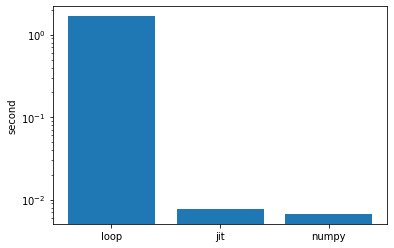

In [144]:
t0 = time.time()
c = [f_loop(i) for i in range(1000)]
t1 = time.time()
c = [f_jit(i) for i in range(1000)]
t2 = time.time()
c = [f_numpy(i) for i in range(1000)]
t3 = time.time()
plt.bar(["loop", "jit", "numpy"], [t1-t0, t2-t1, t3-t2])
plt.ylabel("second")
plt.yscale('log')

## More on Numba

- **vectorize**: you can vectorize a function so that it becomes the element-wise function for numpy array.
- **optimization**: jit compilation would optimize your code.

In [145]:
from math import sin
@numba.vectorize()
def nbvc_sin2(x):
    return sin(x)*sin(x)
@numba.vectorize()
def nbvc_sin(x):
    return sin(x)

In [146]:
%%time
for i in range(10000):
    nbvc_sin2(a)

CPU times: user 819 ms, sys: 0 ns, total: 819 ms
Wall time: 823 ms


second time

In [147]:
%%time
for i in range(10000):
    nbvc_sin2(a)

CPU times: user 754 ms, sys: 0 ns, total: 754 ms
Wall time: 753 ms


In [148]:
%%time
for i in range(10000):
    np.sin(a)*np.sin(a)

CPU times: user 1.65 s, sys: 0 ns, total: 1.65 s
Wall time: 1.65 s


The numpy calculation above is much slower since sin function is excuted twice.<br>
**Due to optimization, numba could be much faster than vectorizing operation of numpy(if you are not careful while coding)**

In [149]:
%%time
for i in range(10000):
    np.sin(a)**2

CPU times: user 812 ms, sys: 2.06 ms, total: 814 ms
Wall time: 811 ms


## multiprocessing

You can parallelize loop with **multiprocessing.pool** to do calculation with many cores.

In [151]:
%%time
c = []
for i in range(1,20001):
    a = np.random.randn(i)
    b = np.random.randn(i)
    c.append((a*b).sum())

CPU times: user 6.4 s, sys: 3.37 ms, total: 6.4 s
Wall time: 6.4 s


In [152]:
%%time
def f(x):
    a = np.random.randn(x)
    b = np.random.randn(x)
    return (a*b).sum()
with Pool(5) as p:
    c = p.map(f, list(range(20000)))

CPU times: user 22.6 ms, sys: 150 ms, total: 172 ms
Wall time: 1.83 s


stackoverflow: multiprocessing, pickle

### Simple way - use jit with parallelization

In [163]:
@numba.jit(parallel=True)
def nb_pl_product_sum():
    c = np.zeros(20001)
    for i in numba.prange(1, 20001):
        a = np.random.randn(i)
        b = np.random.randn(i)
        c[i-1] = (a*b).sum()
    return c

In [164]:
%%time
c = nb_pl_product_sum()

CPU times: user 9.84 s, sys: 10.6 ms, total: 9.86 s
Wall time: 1.51 s


second time

In [165]:
%%time
c = nb_pl_product_sum()

CPU times: user 9.46 s, sys: 0 ns, total: 9.46 s
Wall time: 1.08 s


## Torch - Using the Power of GPU

![gpuvscpu.png](gpuvscpu.png)

- Nvidia RTX 3080: 8960 cores
- Intel Core i9-11900K : 8 cores

**If your calculation can be parallelized, GPU might be faster for large-scale arithmetic calculation.**
 
### Pytorch

**"PyTorch is an optimized tensor library for deep learning using GPUs and CPUs."**
- GPU supported
- autograd
- DL library

- other choices: jax, cupy

### Comparison between numpy and torch

In [6]:
a = np.random.randn(200000)
b = np.random.randn(200000)

In [7]:
%%time
c = [(a*b).sum() for i in range(1000)]

CPU times: user 146 ms, sys: 0 ns, total: 146 ms
Wall time: 144 ms


In [8]:
torch.set_default_tensor_type(torch.DoubleTensor)
a = torch.randn(200000,device="cuda")
b = torch.randn(200000,device="cuda")
def f_torch(x):
    return (a*b).sum()

In [9]:
%%time
c = [f_torch(i) for i in range(1000)]

CPU times: user 51.4 ms, sys: 52.1 ms, total: 104 ms
Wall time: 102 ms


### Note:
In the case above, the speed-up is not significant since `sum` can not be easily parallelized.<br>
Consider the case below, which is just the element-wise multiplication. We can find the speed-up is significant.

In [12]:

a = np.random.randn(200000)
b = np.random.randn(200000)
def f2_numpy(x):
    c = (a*b)
    return 

In [13]:
%%time
c = [f2_numpy(i) for i in range(1000)]

CPU times: user 69.1 ms, sys: 0 ns, total: 69.1 ms
Wall time: 67.2 ms


In [10]:
torch.set_default_tensor_type(torch.DoubleTensor)
a = torch.randn(200000,device="cuda")
b = torch.randn(200000,device="cuda")

def f2_torch(x):
    c = (a*b)
    return 

In [11]:
%%time
c = [f2_torch(i) for i in range(1000)]

CPU times: user 7.07 ms, sys: 743 µs, total: 7.81 ms
Wall time: 6.57 ms


## More topic - lru_cache
With the decorator `lru_cache`, the return values of certain arguments would be recorded so the calculation won't be executed many times. 

In [112]:
from functools import lru_cache
@lru_cache
def fibonacci_cache(n):
    return fibonacci_cache(n-1) + fibonacci_cache(n-2) if n>=2 else 1

In [113]:
%%time
fibonacci_cache(35)

CPU times: user 39 µs, sys: 3 µs, total: 42 µs
Wall time: 49.1 µs


14930352

In [107]:
def fibonacci(n):
    return fibonacci(n-1) + fibonacci(n-2) if n>=2 else 1

In [111]:
%%time
fibonacci(35)

CPU times: user 1.69 s, sys: 2.58 ms, total: 1.7 s
Wall time: 1.7 s


14930352